In [ ]:
# This ipython notebook shows how to train a GRU-based RNN classifier on IMDB dataset 
# using global pre-trained word vectors and achieve 92.075% test accuracy

In [ ]:
# Titan X Pascal (Driver Version: 375.26)
# Keras Version: 1.2.2
# Theano Version: 0.9.0rc1 (cuda backend)

In [ ]:
"""
TO GET DATA EXECUTE THE FOLLOWING SHELL SCRIPT
# this script is based on https://github.com/mesnilgr/iclr15/blob/master/scripts/data.sh

wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
tar -xvf aclImdb_v1.tar.gz

for j in train/pos train/neg test/pos test/neg train/unsup; do
  for i in `ls aclImdb/$j`; do cat aclImdb/$j/$i >> temp; awk 'BEGIN{print;}' >> temp; done
  mv temp aclImdb/$j/norm.txt
done

mkdir data
mv aclImdb/train/pos/norm.txt data/full-train-pos.txt
mv aclImdb/train/neg/norm.txt data/full-train-neg.txt
mv aclImdb/test/pos/norm.txt data/test-pos.txt
mv aclImdb/test/neg/norm.txt data/test-neg.txt

cd data
head -n 10000 full-train-pos.txt > small-train-pos.txt
head -n 10000 full-train-neg.txt > small-train-neg.txt
tail -n 2500 full-train-pos.txt > valid-pos.txt
tail -n 2500 full-train-neg.txt > valid-neg.txt
cd ..

rm -r aclImdb
rm aclImdb_v1.tar.gz
"""

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu0,floatX=float32"

import numpy as np
np.random.seed(2525)  # for reproducibility

import re
import time
from gensim.models import Word2Vec

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import GRU
from keras.utils.generic_utils import Progbar

from sklearn.metrics import precision_recall_fscore_support as score

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: TITAN X (Pascal) (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5005)


In [2]:
# *******************************************************************************************************************
# ************** 1. LOADING WORD VECTORS AND PREPARING EMBEDDING MATRIX *********************************************
# *******************************************************************************************************************
starttime = time.time()
# to get GoogleNews vectors visit this page https://code.google.com/archive/p/word2vec/
w2vmodel = Word2Vec.load_word2vec_format("../vectors/GoogleNews-vectors-negative300.bin", binary=True)
embedding_matrix = w2vmodel.syn0
# adding padding vector
embedding_matrix = np.insert(embedding_matrix, 0, np.zeros(300), axis=0) # pad index = 0
# adding unknown vector as averaged sum of 100 most rear word vectors based on from word2vec vocad
unk_vec = w2vmodel.syn0[-100:].sum(axis=0)/100
embedding_matrix = np.insert(embedding_matrix, 1, unk_vec, axis=0)  # unk index = 1
print("embedding_matrix: "+str(embedding_matrix.shape)+" "+str(embedding_matrix.dtype))

print ("Took %ds" % (time.time() - starttime))

embedding_matrix: (3000002, 300) float32
Took 26s


In [3]:
# *******************************************************************************************************************
# *************** 2. LOADING AND PREPROCESSING DATA *****************************************************************
# *******************************************************************************************************************
starttime = time.time()

maxlen = 500 #max num of words in sample

def preproc(line):
    # 1. removing stopwords
    line = " ".join([word for word in line.split(" ") if word.lower() not in ["a","to","of","and"]])
    # 2. removing HTML tags
    line = re.sub(r'<[^>]+>', ' ', line)
    # 3. removing URLs
    line = re.sub(r'(https?:\/\/(?:www\.|(?!www))[^\s\.]+\.[^\s]{2,}|www\.[^\s]+\.[^\s]{2,})', ' ', line)
    # 4. removing all non-alphabetic/numerical chars except \s and -
    line = re.sub(r'[^a-zA-Z0-9-\s]', ' ', line)
    # 5. replacing numbers with #
    line = re.sub(r'\d', '#', line)
    # 6. converting words into word ids
    def word2id(word):
        try: return w2vmodel.vocab[word].index+2;
        except: return 1 # unkown word id
    line = [word2id(word) for word in line.split()[-maxlen:]]
    # 7. adding pad vector (pad word id = 0)
    line += [0]*(maxlen-len(line))
    
    return line
    
def load_imdb(filename):
    x,y = [],[]
    # loading negative and positive samples
    for yi,fnsuffix in enumerate(["-neg.txt","-pos.txt"]):
        with open("data/"+filename+fnsuffix, "r") as txtfile:
            for line in txtfile:
                x.append(preproc(line))
                y.append(yi)
                
    return np.array(x,dtype="int32"),np.array(y,dtype="int32")

#x_train,y_train = load_imdb("small-train")
#x_val,y_val = load_imdb("valid")
x_train,y_train = load_imdb("full-train")
x_test,y_test   = load_imdb("test")
print("x_train:"+str(x_train.shape))
print("x_test:"+str(x_test.shape))

print ("Took %ds" % (time.time() - starttime))

x_train:(25000, 500)
x_test:(25000, 500)
Took 103s


In [4]:
# *******************************************************************************************************************
# ************** 3. BUILDING RNN ************************************************************************************
# *******************************************************************************************************************
starttime = time.time()

model = Sequential()
model.add(Embedding(embedding_matrix.shape[0],
                    embedding_matrix.shape[1],
                    weights=[embedding_matrix],
                    input_length=maxlen,
                    trainable=False,
                    mask_zero=True,
                    dropout=0.2))
model.add(GRU(output_dim=64,name="layer01",return_sequences=True,dropout_W=0.22,dropout_U=0.22))
model.add(GRU(output_dim=64,name="layer02",return_sequences=True,dropout_W=0.22,dropout_U=0.22))
model.add(GRU(output_dim=64,name="layer03",return_sequences=True,dropout_W=0.22,dropout_U=0.22))
model.add(GRU(output_dim=64,name="layer04",return_sequences=True,dropout_W=0.22,dropout_U=0.22))
model.add(GRU(output_dim=64,name="layer05",return_sequences=False,dropout_W=0.22,dropout_U=0.22))
model.add(Dense(output_dim=1,name="layer06",activation="sigmoid"))
#model.load_weights("imdb_rnnw2v_140epoch",by_name=True)
model.compile(loss="binary_crossentropy", optimizer="adam",metrics=['accuracy'])
model.summary()

print ("Took %ds" % (time.time() - starttime))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_1 (Embedding)          (None, 500, 300)      900000600   embedding_input_1[0][0]          
____________________________________________________________________________________________________
layer01 (GRU)                    (None, 500, 64)       70080       embedding_1[0][0]                
____________________________________________________________________________________________________
layer02 (GRU)                    (None, 500, 64)       24768       layer01[0][0]                    
____________________________________________________________________________________________________
layer03 (GRU)                    (None, 500, 64)       24768       layer02[0][0]                    
___________________________________________________________________________________________

In [5]:
# to free memory before training
del embedding_matrix
del w2vmodel

Train on 25000 samples, validate on 0 samples
Epoch 1/140
25000/25000 [==============================] - 146s - loss: 0.6555 - acc: 0.6088      

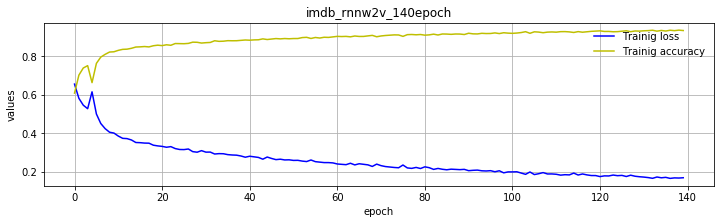

Done!
Took 15964s


In [6]:
# *******************************************************************************************************************
# ************** 4. FINAL TRAINING **********************************************************************************
# *******************************************************************************************************************
starttime = time.time()

def train(x_train,y_train,x_val=np.array([]),y_val=np.array([]),
              nb_epoch=100,save=True,plotMetrics=True):
    
    history = {"loss":[],"acc":[],"val_loss":[],"val_acc":[]}
    
    x_slice_size = 500 # batch_size
    nb_batch = len(x_train)/x_slice_size+(0 if len(x_train)%x_slice_size == 0 else 1)
        
    print('Train on %d samples, validate on %d samples' % (x_train.shape[0], x_val.shape[0]))
        
    for epoch in range(nb_epoch):
        
        print("Epoch "+str(epoch+1)+"/"+str(nb_epoch))
        pbar = Progbar(len(x_train))
        
        shuffledIndices = np.arange(len(x_train))
        np.random.shuffle(shuffledIndices)
        x_train = np.array([x_train[i] for i in shuffledIndices])
        y_train = np.array([y_train[i] for i in shuffledIndices])
            
        for batch in range(nb_batch):
            start = batch*x_slice_size
            stop  = batch*x_slice_size+x_slice_size
            train = model.train_on_batch(x_train[start:stop], y_train[start:stop])
            pbar.update(stop,[("loss",train[0]),("acc",train[1])], force=True)

        history["loss"].append(pbar.sum_values["loss"][0]/float(pbar.sum_values["loss"][1]))
        history["acc"].append(pbar.sum_values["acc"][0]/float(pbar.sum_values["acc"][1]))
        
        if len(x_val):
            val = model.evaluate(x_val, y_val, verbose=1,batch_size=1000)
            history["val_loss"].append(val[0])
            history["val_acc"].append(val[1])
            print("validation: " + str(val))

    name = "imdb_rnnw2v_"+str(nb_epoch)+"epoch"
    
    if save: 
        tmpmodel = Sequential()
        for layer in model.layers[1:]:
            tmpmodel.add(layer)
        tmpmodel.save_weights(name,overwrite=False)
        print("Saved as "+name)
        
    if plotMetrics:
        plt.figure(figsize=(12, 3))
        plt.plot(history['loss'],"b",label='Trainig loss')
        plt.plot(history['acc'],"y",label='Trainig accuracy')
        if len(x_val):
            plt.plot(history['val_loss'],"g",label='Validation loss')
            plt.plot(history['val_acc'],"r",label='Validation accuracy')
        plt.ylabel('values')
        plt.xlabel('epoch')
        plt.title(name)
        plt.grid(True)
        leg = plt.legend(loc=1,fancybox=True)
        leg.get_frame().set_alpha(0.0)
        plt.show()

    print("Done!")
    
train(x_train,y_train,nb_epoch=140)
    
print ("Took %ds" % (time.time() - starttime))

In [7]:
# *******************************************************************************************************************
# ************** 5. EVALUATION **************************************************************************************
# *******************************************************************************************************************
print(model.evaluate(x_test,y_test,batch_size=1000))

# F1 score
predictions = model.predict(x_test,batch_size=1000, verbose=1)
p = (predictions[:,0]>=0.5).astype(int) 
precision, recall, fscore, support = score(y_test, p)
precision = np.around(precision*100,decimals=2)
recall = np.around(recall*100,decimals=2)
fscore = np.around(fscore*100,decimals=2)           
print("labels    :[ neg    pos]")
print("precision :"+str(precision))
print("recall    :"+str(recall))
print("fscore    :"+str(fscore))
print("-"*25)
print("fscore.mean: "+str(fscore.mean()))
print("test distribution :"+str(support))
        

25000/25000 [==============================] - 15s     

Train on 20000 samples, validate on 5000 samples
Epoch 1/200
5000/5000 [==============================] - 3s     
validation: [0.58315455913543701, 0.70420000553131101]
Epoch 2/200
5000/5000 [==============================] - 3s     
validation: [0.47238569855690005, 0.78379999399185185]
Epoch 3/200
5000/5000 [==============================] - 3s     
validation: [0.4913167

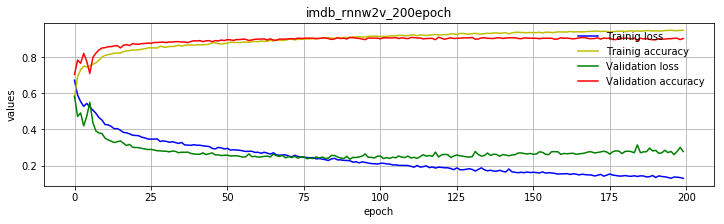

Done!
Took 19260s


In [7]:
# if you want to tune parameters yourself use "small-train" and "valid" datasets 
# to avoid testset overfitting 
# x_train,y_train = load_imdb("small-train")
# x_val,y_val = load_imdb("valid")

starttime = time.time()

train(x_train,y_train,x_val,y_val,nb_epoch=200)
    
print ("Took %ds" % (time.time() - starttime))